This is an example how Spectra of SDSS can be retrieved programmatically.

The below notebook is split into two sections:
- The first part is an example of how a fits file can be loaded and how a spectrum can be produced
- The second part loads multiple fits files and combines them into a single spectrum

Useful tutorials to understand the below code:
* https://www.w3schools.com/python/python_lists.asp
* https://numpy.org/doc/stable/user/quickstart.html
* https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
* https://matplotlib.org/stable/tutorials/introductory/pyplot.html
* https://seaborn.pydata.org/introduction.html

Feel free to create your own copy and experiment with the code (File --> Save as --> your name)

# Individual Spectrum

## Import third party libraries

In [7]:
import io # to read csv strings

from astropy.io import fits  # processing fits files
from astropy.table import Table  # fits table (converted to pandas)

import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting

import numpy as np  # array processing
import pandas as pd  # excel on steroids

from tqdm.notebook import tqdm  # progress bar
from urllib.parse import urlencode  # format sql for accessing sql server
from urllib.request import urlopen  # accessing sql server

## Example how to load data for a single fits file

In [8]:
plate = ('{:04}'.format(382)) # the {:04} ensures that the number has 4 digits, so 3 would become 0003
mjd = ('{:05}'.format(51816))
fiber = ('{:04}'.format(368))
red_shift = 0.032125

In [9]:
# filename= f"https://dr12.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/spectra/3851/spec-{plate}-{mjd}-{fiber}.fits"
filename= f"https://dr12.sdss.org/sas/dr12/sdss/spectro/redux/26/spectra/0382/spec-{plate}-{mjd}-{fiber}.fits"
filename

'https://dr12.sdss.org/sas/dr12/sdss/spectro/redux/26/spectra/0382/spec-0382-51816-0368.fits'

In [10]:
# load the fits file
hdul = fits.open(filename)

### Show what's in the header of the fits file

In [11]:
# The FITS file has sections (or boxes) and each box has a header that contains summary info
# Here we are taking the first box, signified by the '[0]', as the sequence starts at zero
header = hdul[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4476921102.82 / 1st row - Number of seconds since Nov 17 1858  
RA      =            349.25606 / 1st row - Right ascension of telescope boresigh
DEC     =            0.028570  / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '04:44:37.89'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                51816 / MJD of observation                             
MJDLIST = '51816   '        

## Create a pandas dataframe with the data part of the fits file

In [12]:
# convert fits table to pandas dataframe
df=Table.read(filename, format='fits').to_pandas()
df

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,8.917456,3.5799,0.068828,0,0,1.088432,9.356971,1.787954
1,3.548576,3.5800,0.068755,0,1048576,1.088222,9.012352,0.928794
2,-0.365291,3.5801,0.067903,0,1048576,1.088012,8.699478,1.142175
3,7.698964,3.5802,0.060656,0,1048576,1.087799,8.441914,1.406451
4,4.982407,3.5803,0.059028,0,1048576,1.087587,8.223914,0.651293
...,...,...,...,...,...,...,...,...
3841,13.971910,3.9640,0.516393,0,0,0.877986,4.472544,11.241868
3842,12.793783,3.9641,0.460204,0,0,0.878017,4.990633,11.044127
3843,12.720782,3.9642,0.395765,0,0,0.878048,5.684227,11.058768
3844,12.907355,3.9643,0.393288,0,0,0.878079,6.098460,10.726291


### Calculate the normlization factor

In [13]:
normalization_value=df['flux'].mean()
normalization_value

11.114709

In [14]:
df['flux_normalized'] = df['flux'] / normalization_value

## Redshift

In [15]:
# obtain the frequency in angstroms:
df['freq']=10 ** df['loglam']
# Use the equation omitted = observed/(1+z) adjusting the observed wavelength to get the omitted:
df['frez_z_adj'] = df['freq'] / (1+red_shift)

### Plot a histogram

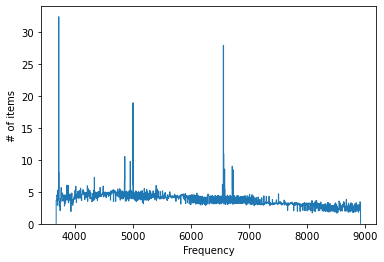

In [16]:
num_bins = 1000
# plot (matplotlib libaray) automatically generates a histogram, look at matplotlib documentation for more details
diagram = plt.hist(x=df['frez_z_adj'], weights=df['flux_normalized'], bins=num_bins, histtype='step')
plt.xlabel('Frequency')
plt.ylabel("# of items")
plt.show()

# Putting multiple spectra together

In [17]:
# define function that is used to connect to the sdss database with the sql query
def get_csv_from_sql(sql):
    url='http://skyserver.sdss3.org/public/en/tools/search/x_sql.aspx'
    params = urlencode({'cmd': sql, 'format': 'csv'})
    df=pd.read_csv(urlopen(url+'?%s' % params), header=1)  # read the sql and put it into a pandas dataframe
    return df

In [18]:
# define function to create the URL to download the a fits file
def generate_url_for_fits_file(plate, mjd, fiber):
    if survey=='legacy':
        v='26'
        name='sdss'
    else:
        v='v5_7_0'
        name='boss'
    return f"https://dr12.sdss.org/sas/dr12/{name}/spectro/redux/{v}/spectra/{plate}/spec-{plate}-{mjd}-{fiber}.fits"

In [128]:
# THIS IS TO SELECT THE BOSS DATA:

sql_boss="""
SELECT      TOP 1000
            plate, mjd, fiberID, z as redshift
            -- ,specObjId, bestObjId, ra, dec, zErr
            -- ,spectroFlux_u, spectroFlux_g, spectroFlux_r, spectroFlux_i, spectroFlux_z
            -- ,concat('http://skyserver.sdss.org/dr12/en/tools/quicklook/summary.aspx?sid=',specObjId) as 'Link'
FROM        specObj
WHERE       z >= 2.0 AND z < 3.0
    AND     class = 'QSO' -- we need to resolve the ambiguity around whether this doesn't exclude QSOs based on angle
    AND     zWarning = 0
    AND     programName='boss'
    AND     (spectroFlux_u>=0 AND spectroFlux_g>=0 AND spectroFlux_r>=0 AND spectroFlux_i>=0 AND spectroFlux_z>=0)
ORDER BY    specObjID -- we assume this is an arbitrary ID so that picking the top 350 won't unduly skew data
"""

In [129]:
# THIS IS TO SELECT THE LEGACY DATA:

sql_legacy="""
SELECT      TOP 1000
            plate, mjd, fiberID, z as redshift
FROM        specObj
WHERE       z >= 0.8 AND z < 2.0
    AND     class = 'QSO' -- we need to resolve the ambiguity around whether this doesn't exclude QSOs based on angle
    AND     zWarning = 0
    AND     programName='legacy'
    AND     (spectroFlux_u>=0 AND spectroFlux_g>=0 AND spectroFlux_r>=0 AND spectroFlux_i>=0 AND spectroFlux_z>=0)
ORDER BY    specObjID -- we assume this is an arbitrary ID so that picking the top 350 won't unduly skew data
"""



In [130]:
lines_csv="""Line Name,Frequency
S VI,937.06
Lyy,972.54
C III,977.02
N III,990.98
Ly?,1025.72
O VI,1033.82
He II,1084.94
Si II,1194.1
Lya,1215.67
O V,1218.34
N V,1240.15
Si II,1263.31
O I,1303.49
Si II,1307.64
C II,1335.31
Si IV,1396.76
O IV],1402.34
N IV],1486.5
Si II,1531.18
C IV,1549.05
He II,1640.42
O III],1664.15
Al II,1670.79
N III],1750.46
Si II,1813.98
Al III,1857.4
Si III],1892.03
C III],1908.73
N II],2141.36
C II],2326.58
[Ne IV],2418.7
Mg II,2797.92
He II,3203.07
[Ne V],3345.83
[Ne V],3425.87
[O II],3726.67
[Ne III],3868.75
He I,3888.65
[Ne III],3967.47
[S II],4068.6
[S II],4076.35
[O III],4363.21
He II,4685.65
[Ar IV],4711.34
[Ar IV],4740.2
H?,4861.32
[O III],4958.91
[O III],5006.84
[N I],5199.82
[Ca V],5309.18
[Fe VII],5721.11
[N II],5754.57
He I,5875.7
[Fe VII],6086.92
[O I],6300.3
[O I],6363.78
[Fe X],6374.53
Ha,6562.8
[N II],6548.06
[N II],6583.39
[S II],6716.47
[S II],6730.85
O I,8446.5
"""
lines_df=pd.read_csv(io.StringIO(lines_csv), sep=",")
lines_df

,Line Name,Frequency
0,S VI,937.06
1,Lyy,972.54
2,C III,977.02
3,N III,990.98
4,Ly?,1025.72
...,...,...
58,[N II],6548.06
59,[N II],6583.39
60,[S II],6716.47
61,[S II],6730.85


## SWITCH BETWEEN legacy AND boss

In [147]:
# make a selection whether to run the sdss or legacy survey
survey = 'boss'

## Determine the target URL

In [148]:
# This function will help later to generate a link to the FITS file

if survey == 'legacy':
    print('Legacy CSV chosen...')
    source_df = get_csv_from_sql(sql_legacy)  # call the get_csv_from_sql function that was defined above
elif survey=='boss':
    print('Boss CSV chosen...')
    source_df = get_csv_from_sql(sql_boss)  # call the get_csv_from_sql function that was defined above
else:
    raise NotImplemented("Selection is not implemented.")

print("Example url:", generate_url_for_fits_file('1234', '12345', '4321'))
# source_df = source_df.sort_values('redshift').reset_index()

Boss CSV chosen...
Example url: https://dr12.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/spectra/1234/spec-1234-12345-4321.fits


In [149]:
source_df


,plate,mjd,fiberID,redshift
0,3655,55240,2,2.355238
1,3655,55240,26,2.248765
2,3655,55240,30,2.374581
3,3655,55240,70,2.374820
4,3655,55240,100,2.439734
...,...,...,...,...
995,3681,55243,14,2.176859
996,3681,55243,30,2.192952
997,3681,55243,48,2.490661
998,3681,55243,76,2.758696


## Download fits files, normalize fluxes and z-adjust frequencies

In [150]:
dfs = []  # create an empty list where we can put all the datafrmes of individual spectra in it
# loop over each row in source_df dataframe and show a tqdm progress bar
for index, _ in tqdm(source_df.iterrows(), total=len(source_df)):
    
    # format the plate, mid and fiber number into a string with the correct format (preceeding zeros etc)
    plate = ('{:04}'.format(source_df.iloc[index].astype(int)['plate']))
    mjd = ('{:05}'.format(source_df.iloc[index].astype(int)['mjd']))
    fiber = ('{:04}'.format(source_df.iloc[index].astype(int)['fiberID']))
    red_shift = source_df.iloc[index]['redshift']
    
    #full_url=f"https://dr12.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/spectra/{plate}/spec-{plate}-{mjd}-{fiber}.fits"
    #full_url=f"https://dr12.sdss.org/sas/dr12/sdss/spectro/redux/26/spectra/{plate}/spec-{plate}-{mjd}-{fiber}.fits"
    
    # call the generate_url_for_fits_file function that we defined above and pass plate, mjd and fiber as arguments
    full_url=generate_url_for_fits_file(plate, mjd, fiber)

#     print(f"loading fits file {full_url}")

    hdul = fits.open(full_url)  # open the fits file
    df=Table.read(full_url, format='fits', hdu=1).to_pandas()  # read first table of fits file and create pandas dataframe
    
    df['freq']=10 ** df['loglam']  # inverstion of log10: 10^loglam gives us the frequency values
    df['freq_z_adj'] = df['freq'] / (1+red_shift)  # calculate the red-shift adj frequencies and put it in a new column

    # filer out negative flux values
    # df = df[df['flux']>0]

    dfs.append(df) # add the dataframe df to the list of dataframes dfs
    
    try:
        red_shift_str = str(round(source_df.iloc[index]['redshift'],2)).replace('.','_')
        folder="C:/Users/dickr/Dropbox/Schools/OU/S382 - Astronomy/sdss project data"
        filename_save = rf"{folder}/{survey}-{index}-{red_shift_str}-{plate}-{mjd}-{fiber}"
        hdul.writeto(f"{filename_save}.fits")
        df.to_csv(f'{filename_save}.csv')
    except IOError:
        pass

  0%|          | 0/1000 [00:00<?, ?it/s]

## Determine overlaps of all spectra

In [161]:
mins=[]  # dreate an empty list that we can later populate
maxes=[]  # empty list to populate
for df in dfs:  # loop over all spectra (stored in the dfs list). Each list element is a df (pandas dataframe)
    mins.append(df['freq_z_adj'].min())  # get the min value of that df and add it to the mins list
    maxes.append(df['freq_z_adj'].max())  # get the max value of the df and add it to the maxes list
    
hist_min=np.max(mins)  # take the max of the mins list
hist_max=np.min(maxes)  # take the mins of the maxes list
print(f"Common minimum is {hist_min} and maximum is {hist_max}")

Common minimum is 1274.07568359375 and maximum is 2577.465087890625


In [162]:
if survey=='boss':
    hist_min = 1000
    hist_max = 3500
if survey=='legacy':
    hist_min = 1200
    hist_max = 5000


In [163]:
source_df

,plate,mjd,fiberID,redshift,Normalization,Index,Average_flux
0,3655,55240,2,2.355238,27.494975,0.0,3.637028
1,3655,55240,26,2.248765,159.915191,1.0,0.625331
2,3655,55240,30,2.374581,15.764482,2.0,6.343374
3,3655,55240,70,2.374820,223.676291,3.0,0.447075
4,3655,55240,100,2.439734,209.610892,4.0,0.477074
...,...,...,...,...,...,...,...
995,3681,55243,14,2.176859,43.129640,995.0,2.318591
996,3681,55243,30,2.192952,57.617220,996.0,1.735592
997,3681,55243,48,2.490661,113.410924,997.0,0.881749
998,3681,55243,76,2.758696,211.271864,998.0,0.467616


In [164]:
# Normalization: add the flux_normalized column to each dataframe, after we know where they all overlap
for i, df in enumerate(dfs):
    multiplier = 100
    normalization_value=multiplier / df[(df['freq_z_adj']>hist_min) & (df['freq_z_adj']<hist_max)] ['flux'].mean() # calculate the mean of the flux column between the overlapping region
    df['flux_normalized'] = df['flux'] / normalization_value # create a new column with normalized flux values
    source_df.at[i, 'Normalization'] = normalization_value
    source_df.at[i, 'Index'] = int(i)
    source_df.at[i, 'Average_flux'] = df['flux'].mean()

In [165]:
# Save summary
source_df.to_csv(f'{folder}/source_summary_{survey}.csv')
source_df

,plate,mjd,fiberID,redshift,Normalization,Index,Average_flux
0,3655,55240,2,2.355238,27.494975,0.0,3.637028
1,3655,55240,26,2.248765,159.915191,1.0,0.625331
2,3655,55240,30,2.374581,15.764482,2.0,6.343374
3,3655,55240,70,2.374820,223.676291,3.0,0.447075
4,3655,55240,100,2.439734,209.610892,4.0,0.477074
...,...,...,...,...,...,...,...
995,3681,55243,14,2.176859,43.129640,995.0,2.318591
996,3681,55243,30,2.192952,57.617220,996.0,1.735592
997,3681,55243,48,2.490661,113.410924,997.0,0.881749
998,3681,55243,76,2.758696,211.271864,998.0,0.467616


## Set bin sizes, and calculate bins for final histogram



In [166]:
bins = 1000  # set an arbitrary value that determines how many bins we want in the histogram
steps = int((hist_max-hist_min) / bins)  # calculate the width of one histogram value
# create a numpy array https://numpy.org/doc/stable/reference/generated/numpy.arange.html
bins=np.arange(hist_min, hist_max, steps)  # create a numpy array with all the bin cutoff points

## Generate individual histograms with pre-determined bins

In [167]:
histograms=[]  # create an empty list that we can use to populate all the individual histograms
for df in dfs:  # iterate over all the dataframes
    # create a histogram (using the numpy histogram function) and add it to the histograms list
    # for documentation of the numpy histograms function check out: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
    histograms.append(np.histogram(df['freq_z_adj'], weights=df['flux_normalized'], bins=bins)[0])

## Combine individual spectrum histograms by averaging the values over their respective bins

In [168]:
# combine all the histograms by creating a new array
# https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
# then reshape it into a 2d array (i.e. a table where each row is a histogram using reshape)
# https://numpy.org/doc/stable/reference/generated/numpy.reshape.html. 
# then create a pandas dataframe out of that and name the columns with our bins values
output_df=pd.DataFrame(np.concatenate(histograms).reshape(-1, len(bins)-1), columns=bins[0:-1])

# rotate the table so all columns become a new row as well (check https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html)
output_df=output_df.stack().reset_index().rename(columns={'level_0':'Sample', 'level_1':"Frequency", 0:"Flux"})

In [169]:
output_df.sort_values('Flux', ascending=False)

,Sample,Frequency,Flux
876906,702,1216,468.970215
876909,702,1222,468.908203
876905,702,1214,463.729004
876907,702,1218,461.950684
876908,702,1220,451.924316
...,...,...,...
926543,741,3068,-5.602417
744176,595,3042,-5.752106
292063,233,3092,-6.192383
741715,593,3116,-6.196289


In [170]:
output_df=output_df[output_df['Flux']>0]
output_df['Flux SQRT'] = np.sqrt(output_df['Flux'])

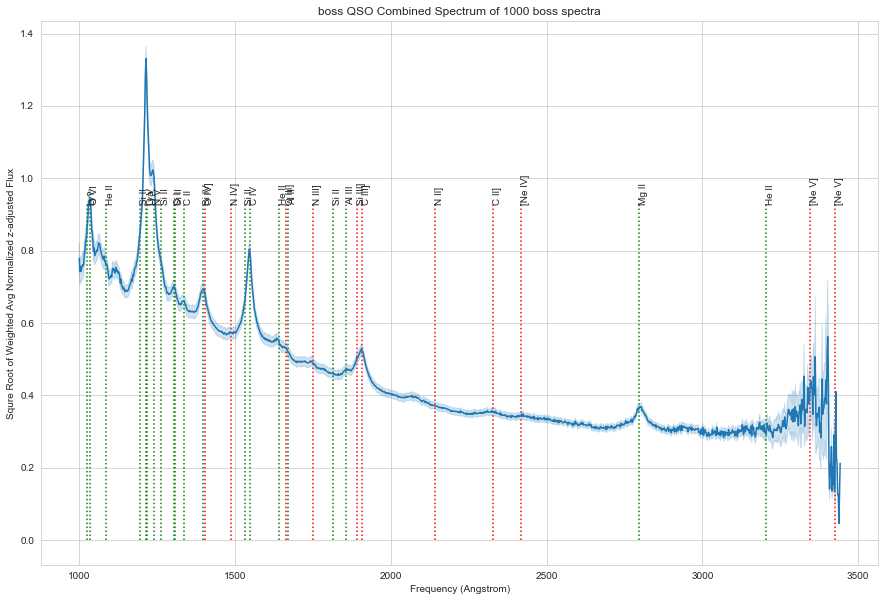

In [174]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title(f"{survey} QSO Combined Spectrum of {len(dfs)} {survey} spectra")
plt.xlabel('Frequency (Angstrom)')
plt.ylabel("Squre Root of Weighted Avg Normalized z-adjusted Flux")
sns.set_style("whitegrid")  # use seaborn to do the final plot

lp = sns.lineplot(x="Frequency", y="Flux SQRT", data=output_df, ci=50, estimator='mean', ax=ax)

maxy = output_df.groupby('Sample').mean()['Flux SQRT'].mean() * 2
filtered_lines_df = lines_df[(lines_df['Frequency']>output_df['Frequency'].min()) & (lines_df['Frequency']<output_df['Frequency'].max())]

colors=[]
for _, line in filtered_lines_df.iterrows():
    ax.annotate(text=line['Line Name'], xy=(line['Frequency'], maxy), rotation = 90)
    if '[' in line ['Line Name'] or ']' in line ['Line Name']:
        colors.append('red')
    else:
        colors.append('green')

ax.vlines(filtered_lines_df['Frequency'],
          ymin=0, ymax=maxy, color=colors, linestyles='dotted')



  0%|          | 0/30 [00:00<?, ?it/s]

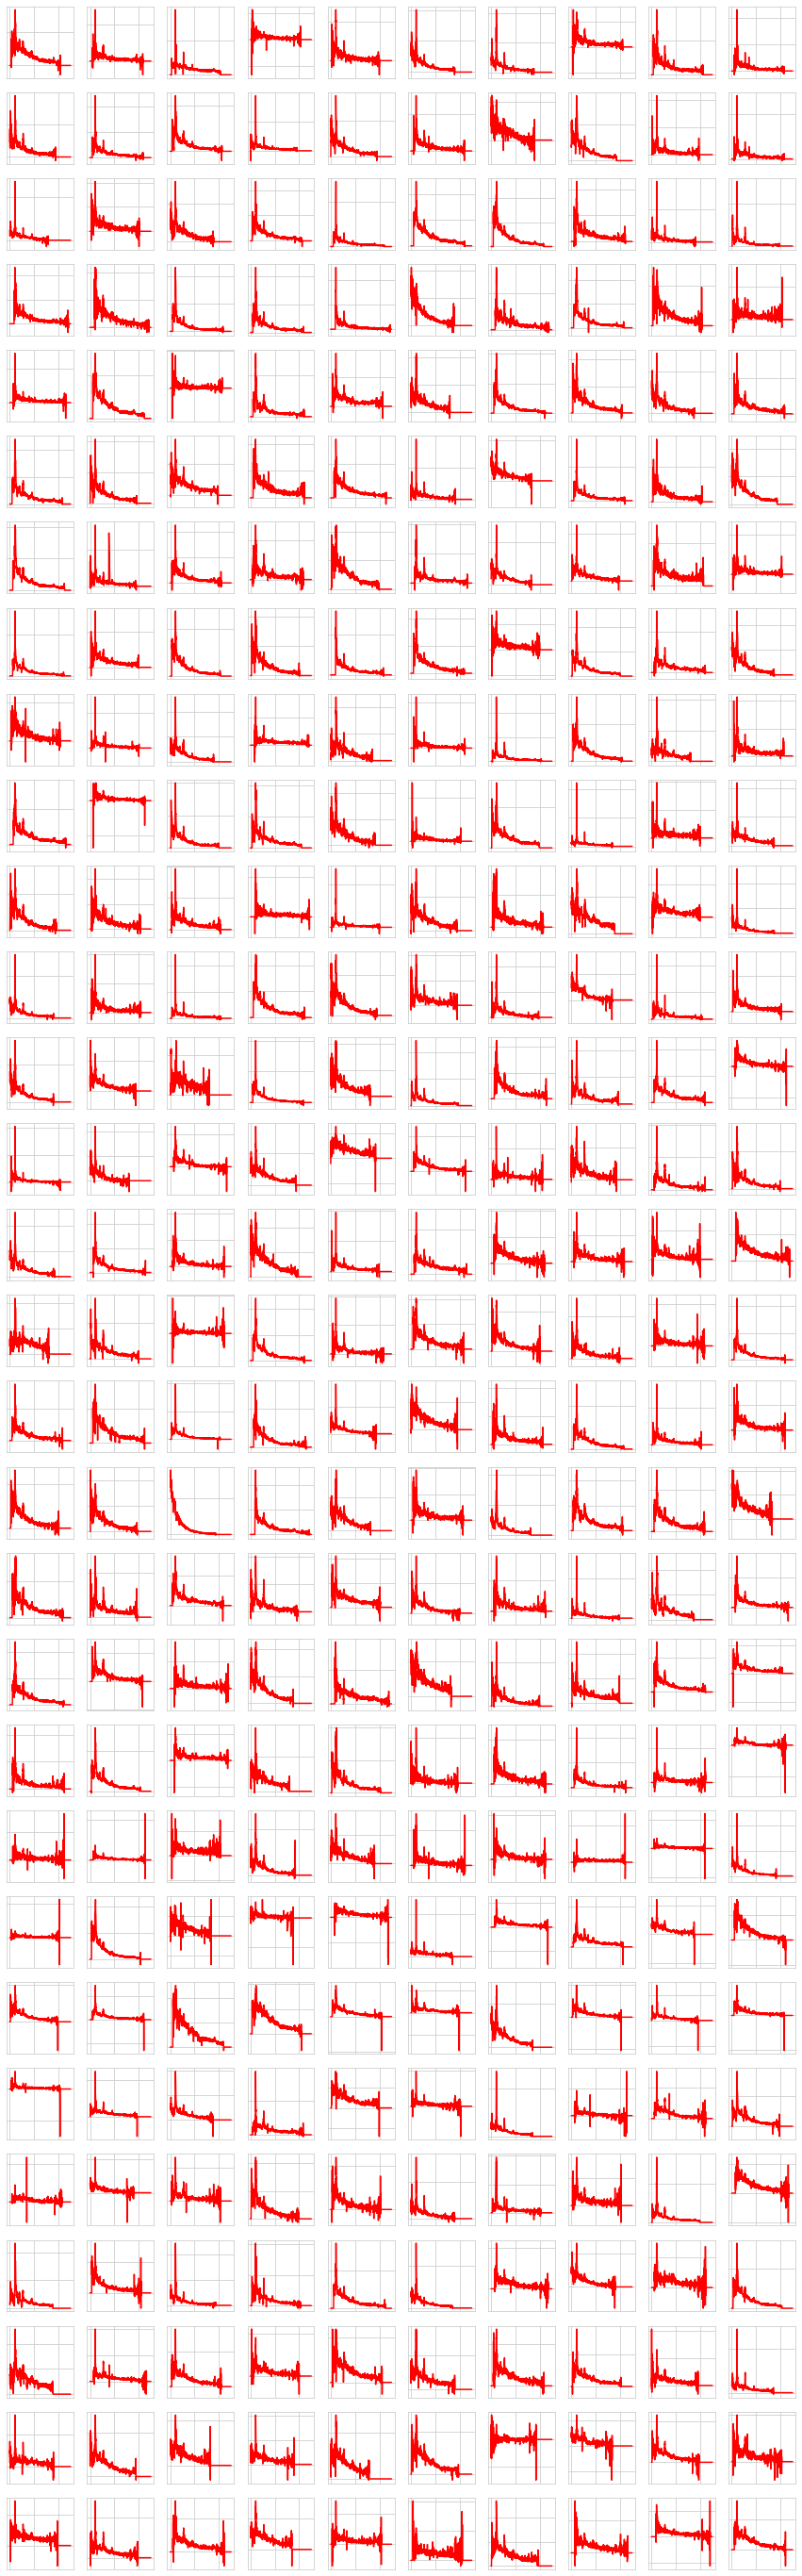

In [173]:

output_df2=pd.DataFrame(np.concatenate(histograms).reshape(-1, len(bins)-1), columns=bins[0:-1])

columns = 10
rows = 30
n=0
fig, ax_array = plt.subplots(rows, columns,squeeze=False,figsize=(15,50))
for i,ax_row in tqdm(enumerate(ax_array), total=rows):
    for j,axes in enumerate(ax_row):
        # axes.set_title('{},{}'.format(i,j))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        axes.plot(output_df2.iloc[n],'r-')
        n+=1
plt.show()


